In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from keras.utils import np_utils

In [ ]:
# df = pd.read_csv("./datasets/fer2013.csv")
df = pd.read_csv("/content/drive/MyDrive/datasets/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.shape

(35887, 3)

In [ ]:
emotion_dict = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}

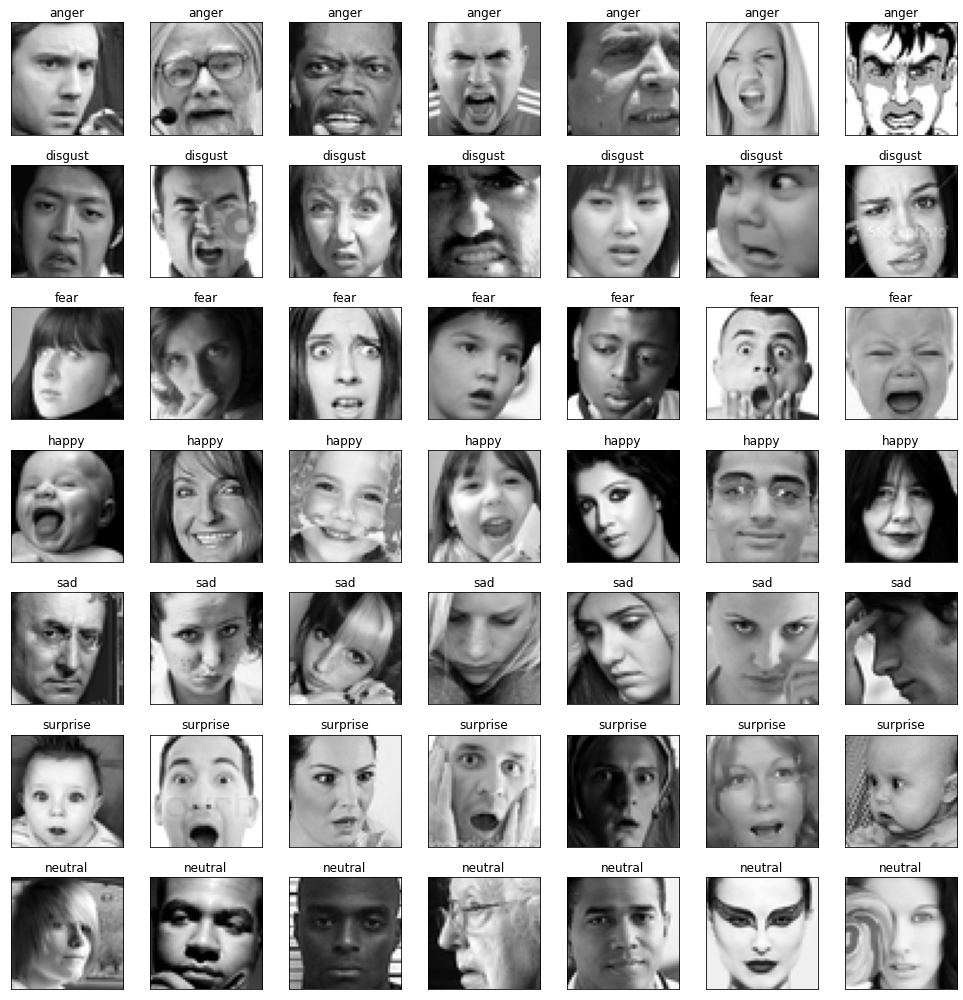

In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_dict[label])
        plt.tight_layout()

In [ ]:
img_pixels = df.pixels.apply(lambda x:np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_pixels.shape

(35887,)

In [ ]:
X = np.stack(img_pixels, axis=0)
X.shape

(35887, 48, 48, 1)

In [ ]:
y = np_utils.to_categorical(df.emotion)
y.shape

(35887, 7)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [ ]:
X_train = X_train/255.
X_valid = X_valid/255.

In [ ]:
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
IMG_CCHANEL = X_train.shape[3]
TOTAL_CLASSES = y_train.shape[1]
 

In [ ]:
def build_model():
  model = tf.keras.models.Sequential()

  model.add(layers.Conv2D(filters=64, kernel_size=(5,5), input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CCHANEL), activation='elu',kernel_initializer='he_normal', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=64, kernel_size=(5,5), activation='elu',kernel_initializer='he_normal', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.4))

  model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu',kernel_initializer='he_normal', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu',kernel_initializer='he_normal', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.4))

  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu',kernel_initializer='he_normal', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu',kernel_initializer='he_normal', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.5))

  model.add(layers.Flatten())

  model.add(layers.Dense(128, activation='elu',kernel_initializer='he_normal'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(TOTAL_CLASSES, activation='softmax'))

  model.compile(loss='categorical_crossentropy', 
        optimizer=optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        metrics=['accuracy'])
# , optimizers.Adam(0.001)
  model.summary()

  return model


In [ ]:
early_stopping = callbacks.EarlyStopping(
  monitor='val_accuracy',
  min_delta=0.00005,
  patience=11,
  verbose=1,
  restore_best_weights=True
)

lr_scheduler = callbacks.ReduceLROnPlateau(
  monitor='val_accuracy',
  factor=0.5,
  patience=7,
  min_lr=1e-7,
  verbose=1
)

callbacks_list = [early_stopping, lr_scheduler]

In [ ]:
train_datagen = ImageDataGenerator(
  rotation_range=15,
  width_shift_range=0.15,
  height_shift_range=0.15,
  shear_range=0.15,
  zoom_range=0.15,
  horizontal_flip=True
)

train_datagen.fit(X_train)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100

In [ ]:
model = build_model()

print(model.summary())

history = model.fit(
  train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
  # X_train, y_train, batch_size=BATCH_SIZE,
  validation_data=(X_valid, y_valid),
  steps_per_epoch=len(X_train) / BATCH_SIZE,
  epochs=EPOCHS,
  callbacks=callbacks_list,
  verbose=1
  # use_multiprocessing=True,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [ ]:
model.save("/content/drive/MyDrive/models/mrfer_model.h5")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

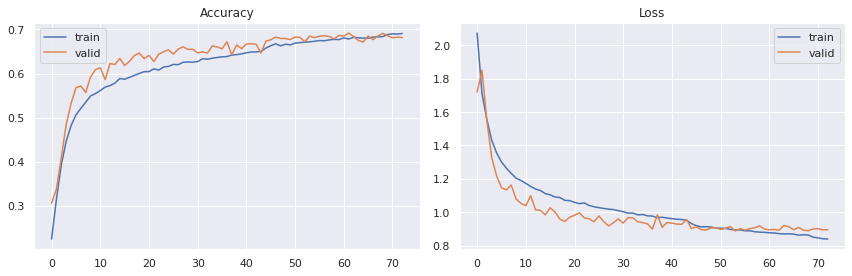

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

In [ ]:
!pip install scikit-plot
import scikitplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


113/113 [==============================] - 1s 7ms/step


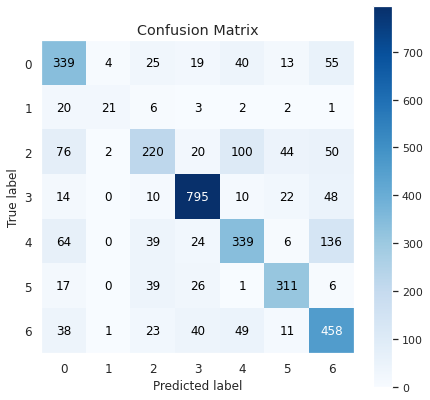

In [ ]:
yhat_valid = model.predict(X_valid) 
yhat_valid=np.argmax(yhat_valid,axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis = 1), yhat_valid, figsize=(7,7))

In [ ]:
from skimage import io
from tensorflow.keras.utils import load_img

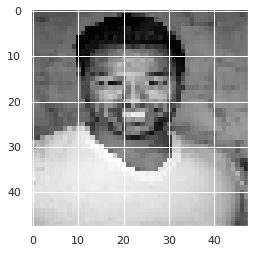

In [ ]:
img = load_img('/content/drive/MyDrive/models/face_images/happy1.jpg', grayscale=True, target_size=(48,48))
plt.gray()
plt.imshow(img)

In [ ]:
img_x = tf.keras.utils.img_to_array(img)
img_x = np.expand_dims(img_x, axis=0)
img_x.shape

(1, 48, 48, 1)

In [ ]:
img_x /= 255.
img_y = model.predict(img_x)
emotion = emotion_dict[img_y[0].argmax()]
print(emotion)

1/1 [==============================] - 0s 16ms/step
happy


1/1 [==============================] - 0s 31ms/step
anger
[[8.5815960e-01 7.3378586e-04 3.6887411e-02 7.4274957e-02 2.4099426e-02
  1.0559162e-03 4.7888448e-03]]


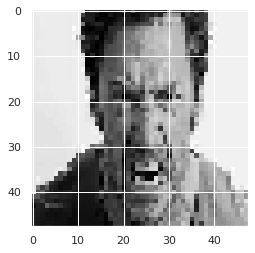

In [ ]:
img = load_img('/content/drive/MyDrive/models/face_images/angry5.jpg', grayscale=True, target_size=(48,48))
# img2 =  load_img('/content/drive/MyDrive/models/face_images/angry3_3.jpg', grayscale=True, target_size=(300,300))
plt.gray()
plt.imshow(img)
img_x = tf.keras.utils.img_to_array(img)
img_x = np.expand_dims(img_x, axis=0)
img_x.shape
img_x /= 255.
img_y = model.predict(img_x)
emotion = emotion_dict[img_y[0].argmax()]
print(emotion)
print(img_y)

In [ ]:
import tensorflowjs as tfjs

<module 'tensorflowjs.version' from '/usr/local/lib/python3.8/dist-packages/tensorflowjs/version.py'>

In [ ]:
saved_model = tf.keras.models.load_model("/content/drive/MyDrive/models/mrfer_model.h5");

In [ ]:
tfjs.converters.save_keras_model(saved_model, '/content/drive/MyDrive/models/fer_tfjs_model')